# (實用) 如何將網路上的資料，放進自己的資料庫中 及 應用處理?!

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 01 讀取網路上的檔案

In [4]:
df = pd.read_csv('https://od.cdc.gov.tw/eic/NHI_EnteroviralInfection.csv')

In [13]:
df.head()

,年,週,就診類別,年齡別,縣市,腸病毒健保就診人次,健保就診總人次
0,2008,14,住院,0-2,台中市,0,105
1,2008,14,住院,0-2,台北市,2,151
2,2008,14,住院,0-2,台東縣,0,14
3,2008,14,住院,0-2,台南市,0,20
4,2008,14,住院,0-2,宜蘭縣,0,44


In [2]:
# 用於顯示中文
import matplotlib as mpl
mpl.rc('font', family='Noto Sans CJK TC')

In [20]:
# 取需要的欄位
df1 = df.loc[:,['年', '週', '年齡別', '縣市', '腸病毒健保就診人次']].copy()

In [30]:
df1.head()

,年,週,年齡別,縣市,腸病毒健保就診人次
0,2008,14,0-2,台中市,0
1,2008,14,0-2,台北市,2
2,2008,14,0-2,台東縣,0
3,2008,14,0-2,台南市,0
4,2008,14,0-2,宜蘭縣,0


# 02 設定並開啟 DB Connect

In [3]:
import pyodbc 
conn = pyodbc.connect('DRIVER={SQL Server}; SERVER=localhost; DATABASE=xxx; UID=xxx; PWD=xxxx')
cursor = conn.cursor()

# 03 將資料新增至資料庫

ref https://tomaztsql.wordpress.com/2018/07/15/using-python-pandas-dataframe-to-read-and-insert-data-to-microsoft-sql-server/

ref https://stackoverflow.com/questions/42286679/pyodbc-params-must-be-in-a-list-tuple-or-row-hy000-with-numpy-data

In [55]:
sql = "INSERT INTO [Reg].[dbo].[Enterovirus] (TheYear, TheWeek, AgeRange, City, Times) VALUES (?, ?, ?, ?, ?)"
val = list(tuple(row) for row in df1.values)

cursor.executemany(sql, val)
conn.commit()

# 04 顯示資料庫中的資料

In [6]:
cursor.execute("SELECT TOP 10 TheYear, TheWeek, AgeRange, City, Times FROM [Reg].[dbo].[Enterovirus];")
rows = cursor.fetchall()
if rows:
    for row in rows:
        print(row.TheYear, row.TheWeek, row.AgeRange, row.City, row.Times) 

2008 14 0-2 台中市 0
2008 14 0-2 台北市 2
2008 14 0-2 台東縣 0
2008 14 0-2 台南市 0
2008 14 0-2 宜蘭縣 0
2008 14 0-2 花蓮縣 0
2008 14 0-2 金門縣 0
2008 14 0-2 屏東縣 0
2008 14 0-2 苗栗縣 0
2008 14 0-2 桃園市 0


# 06 將資料庫中的資料 轉成 dataframe

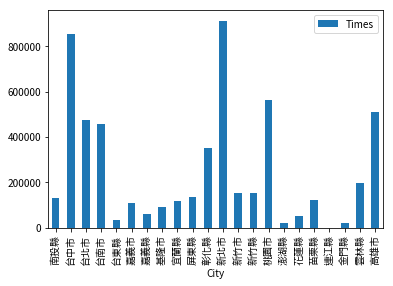

In [43]:
df2 = pd.read_sql("SELECT City, SUM(Times) AS Times FROM [Reg].[dbo].[Enterovirus] GROUP BY City", conn)
df3 = df2.sort_values(by = ['City'], ascending=True)
df3.plot.bar(x='City', y=['Times'])

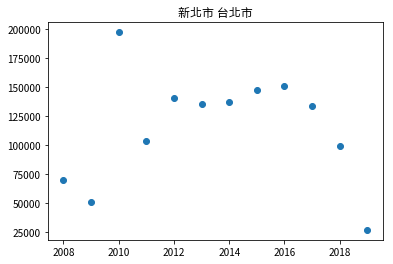

In [32]:
# 將資料庫中的資料 轉成 dataframe (方式二)
df4 = pd.read_sql(
    "SELECT [TheYear], SUM([Times]) AS Times \
     FROM [Reg].[dbo].[Enterovirus] \
     WHERE [City] IN ('新北市', '台北市') \
     GROUP BY [TheYear] \
     ORDER BY [TheYear]"
    , conn)

plt.title('新北市 台北市')
plt.scatter(df4.TheYear, df4.Times)

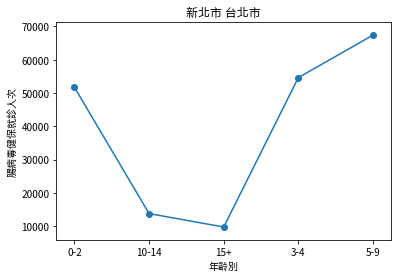

In [73]:
# 將資料庫中的資料 轉成 dataframe (方式三)
df5 = pd.read_sql(
    '''SELECT [AgeRange], SUM([Times]) AS Times
     FROM [Reg].[dbo].[Enterovirus]
     WHERE [City] IN ('新北市', '台北市')
     AND [TheYear] = '2010'
     GROUP BY [AgeRange]
     ORDER BY [AgeRange]'''
    , conn)

plt.title('新北市 台北市')
plt.xlabel('年齡別')
plt.ylabel('腸病毒健保就診人次')
plt.plot(df5.AgeRange, df5.Times)
plt.scatter(df5.AgeRange, df5.Times)

# 07 帶入參數讀取資料庫 並 轉成 dataframe 及 其應用

In [46]:
def Enterovirus01(Year, City):
    df = pd.read_sql("SELECT [AgeRange], SUM([Times]) AS Times FROM [Reg].[dbo].[Enterovirus] WHERE [City] = '{}' AND [TheYear] = '{}' GROUP BY [AgeRange] ORDER BY [AgeRange]".format(City, Year), conn)
    PltDraw(City, df.AgeRange, df.Times)

In [47]:
# 將資料庫中的資料 帶入參數 並 轉成 dataframe 及 其應用 (方式二)
#ref https://andypicke.github.io/sql_pandas_post/
def Enterovirus02(Year, City):
    df = pd.read_sql_query('''SELECT AgeRange, SUM(Times) AS Times 
                            FROM [Reg].[dbo].[Enterovirus] 
                            WHERE City = ? AND TheYear = ? 
                            GROUP BY [AgeRange] 
                            ORDER BY [AgeRange] ''', conn, params=[City, Year])    
    PltDraw(City, df.AgeRange, df.Times)

In [48]:
def PltDraw(title, val01, val02):
    plt.title(title)
    plt.xlabel('年齡別')
    plt.ylabel('腸病毒健保就診人次')
    plt.plot(val01, val02)
    plt.scatter(val01, val02)    

Year >> 2010
City >> 高雄市


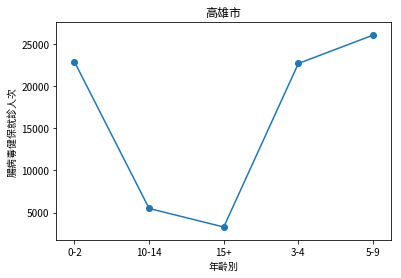

In [50]:
# 資料互動查詢一
from ipywidgets import widgets

Year = input('Year >> ')
City = input('City >> ')
Enterovirus01(Year, City)

In [44]:
# 資料互動查詢二
df6 = pd.read_sql("SELECT [City] FROM [Reg].[dbo].[Enterovirus] GROUP BY [City] ORDER BY [City]", conn)

from ipywidgets import interact
interact(Enterovirus02, Year=(2008, 2019), City=df6.City)

interactive(children=(IntSlider(value=2013, description='Year', max=2019, min=2008), Dropdown(description='Cit…

<function __main__.Enterovirus02(Year, City)>

# 08 年月通報次數 與 腸病毒健保就診人次 相關性回歸分析

In [171]:
df7 = pd.read_sql("SELECT COUNT(*) AS YearWeek, SUM([Times]) AS [Times] \
FROM [Reg].[dbo].[Enterovirus] \
WHERE [Times] > 0 \
GROUP BY [TheYear], [TheWeek] \
ORDER BY [TheYear], [TheWeek]", conn)

x = np.array(df7.YearWeek)
X = x.reshape(len(x), 1)
y = np.array(df7.Times)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9487)

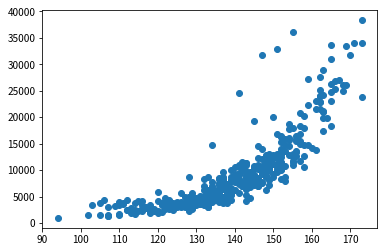

In [172]:
plt.scatter(x_train, y_train)

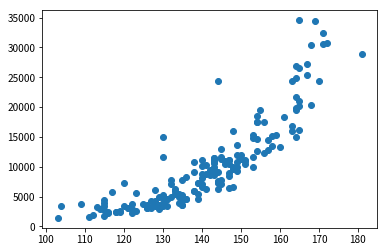

In [173]:
plt.scatter(x_test, y_test)

In [174]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

regr.fit(x_train, y_train)
Y_pred = regr.predict(x_test)

Text(0, 0.5, '腸病毒健保就診人次')

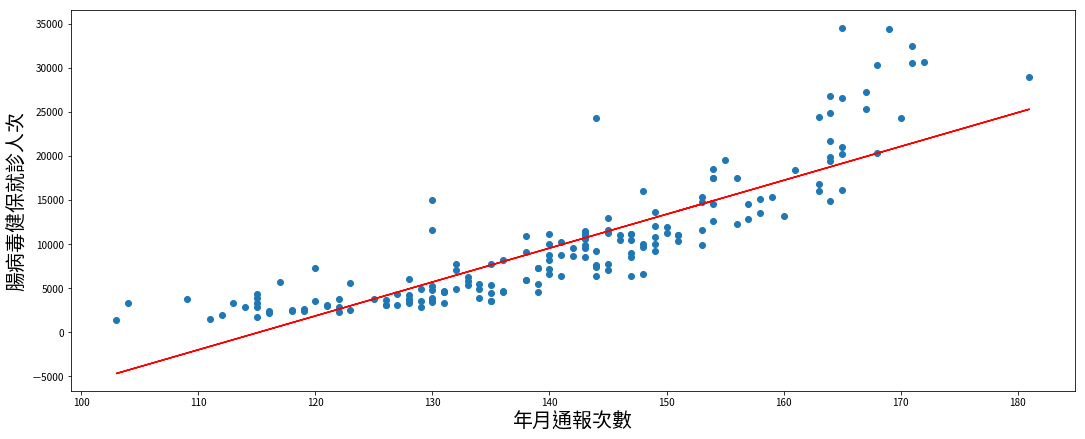

In [177]:
plt.figure(figsize=(18,7))
plt.scatter(x_test, y_test)
plt.plot(x_test, Y_pred, 'r')
plt.xlabel("年月通報次數", size=20)
plt.ylabel("腸病毒健保就診人次", size=20) 

In [178]:
regr.score(x_test, y_test)

0.7427899728838308